# Supermercato 24 
# Recruiting Day Challenge - Summer Internships 

## Analytics - Data Analytics Ninja 
solution provided by: **Daniel Travaglia**

## Outline of the notebook

0. Prerequisites: set up the environment
1. Introduction: frame the problem
2. Retrieve and describe the dataset
3. Discover and visualize data for reacher insights 
4. Data cleaning (missing values)
5. Machine Learning Pipelines:
    - Model (1): Polynomial Regression Model
        1. Data prepocessing and model definition
        2. Model better evaluation using cross validation and fine-tuning model parameters using grid search
        3. Retrieve the optimal model 
    - Model (2): Ensemble Model (Gradient Boosting)
        1. Data preprocessing and model definition
        2. Model better evaluation using cross validation and fine-tuning model parameters using grid search
        3. Retrieve the optimal model
6. Get the best model (metric comparison)
7. Evaluate the system on the test set and plot the results
8. Conclusions
9. (Bonus) Further improvements

## (0) Prerequisites before running the notebook
Before running the following notebook, make sure that you have the following packages and libraries installed on your PC the following packages:

- Python (version 3.7 or higher)
- Libraries:
    - numpy
    - pandas
    - matplotlib
    - seaborn
    - sklearn
    - xgboost

To be able to run the code smoothly, let's make sure that all the libraries and methods are available importing them before getting into the actual workflow.

In [1]:
# LIBRARIES

# Core libraries
import numpy as np
import pandas as pd

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Classes inherited by transformers
from sklearn.base import BaseEstimator,TransformerMixin

# 1st model (Polynomial Regression Model)
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LinearRegression

# 2nd model (Ensemble Model: Gradient Boosting)
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor

## (1) Introduction: frame the problem

**Description**: given a (csv) sample dataset consisting of (x, y) pairs, I am required to perform a regression task. To be more specific, the assignment asks to: propose two different regression models, retrieve the best model through methods of metric evaluation and comparison between models and use it to plot the predictions against the data.  


## (2) Retrieve and describe the dataset
In this section I will open and read the file in order to conduct a preliminary analysis on the overall structure of the data. This is a fundamental step to get the first insights on how to proceed in preparing data before modeling.

In [2]:
# Read and store the dataset
df = pd.read_csv("analytics_task_data.csv")

In [3]:
# Dimension of the dataset
df.shape

(500, 2)

Dealing with a relative small dataset characterized by 500 observations and 2 features.

In [4]:
# Show the first few observations 
df.head()

,x,y
0,8.519119,48.073811
1,12.059918,302.657224
2,11.547357,247.531965
3,10.383055,127.686318
4,8.492261,55.086710


From the results above it is possible to notice that the each observation is described by 2 numerical features. This gives further insights on the problem needed to be tackled: build regression models to predict the target variable "y" using "x", the explanatory variable. 

In [5]:
# Dataset statistics
df.describe()

,x,y
count,488.000000,462.000000
mean,9.767819,133.752630
std,1.614540,91.797160
min,7.007803,10.443932
25%,8.380894,59.919619
50%,9.781597,104.201239
75%,11.122550,194.316855
max,12.498972,375.943890


Having two numerical features, I wish to extract more information by presenting some statistics. The first thing it is possible to notice here is that the two features have different mean and standard deviation, which might suggest that they are sampled from the same distribution with different parameters or that they simply belong to different distributions. In any case, these differences can be ignored for our purposes since they have no consequences on the simple regression task outcomes. Indeed, this would be relevant in case of multiple predictors with different scales and when the aim is to use them jointly to estimate the target variable "y".

Most importantly, it is easy to notice that both columns present missing values, but in different proportions with respect to the overall sample size. This fact requires further attention and needs special treatments when it comes to data preparation.

In [6]:
# Any missing value?
if np.array(df.isnull().any()).any() == True: # TODO: 
    # store missing values information if any
    missing_data_sum = df.isnull().sum()
    # present statistics
    print(f"""Number of missing values :

            x: {missing_data_sum.x} ({missing_data_sum.x/df.shape[0] * 100}% over total sample size) 
            y: {missing_data_sum.y} ({missing_data_sum.y/df.shape[0] * 100}% over total sample size) 
            overall: {missing_data_sum.x+missing_data_sum.y} ({(missing_data_sum.x+missing_data_sum.y)/df.shape[0] * 100}% over total sample size)
    """)

Number of missing values :

            x: 12 (2.4% over total sample size) 
            y: 38 (7.6% over total sample size) 
            overall: 50 (10.0% over total sample size)
    


Each column presents few missing values, and if they are considered jointly, the percentage of total cases with respect to the overall sample size is equal to 10%. At this point, there are two plausible options available that could be adopted in order to take care of the presence of missing observations. Each of these will be further discussed and analyzed in the section relative to data cleaning procedures.


## (3) Discover and visualize data for reacher insights
Here I wish to dig a bit more into the characteristics of our sample through further analysis and data visualization techniques. Visualizing data is a fundamental step in order to deepen the relationship between the predictor(s) and the target variable. The aim of this section is then to uncover relationships that might not be as evident by only analyzing raw data.

In [11]:
# Set up the visualization to get a better experience
sns.set(color_codes=True)

### Correlation analysis
Before proceeding with data visualization techniques, I wish to see how the two features are correlated to one another. In particular, the correlation analysis will give evidence of the strength and direction of the linear relationship between the two variables under scrutiny. Such assessment can be given by analyzing the correlation coefficient:

In [7]:
# Remove missings to calculate correlation coefficient (null values would drop the coefficient to 0)
df_corr = df.dropna(axis=0)
# Retrieve correlation coefficient
corr_coefs = np.corrcoef(df_corr.x.values,df_corr.y.values)
# Get correlation coefficient out there!
print(f"Correlation coefficient between 'x' and 'y' amounts to: {round(corr_coefs[0][1],2)}")

Correlation coefficient between 'x' and 'y' amounts to: 0.95


The correlation coefficient between the explanatory and the target variables results to be highly positive. This suggests that, in most of the cases, increasing one variable would imply higher values also for the other considered variable, and viceversa. This coefficient, along with a relatively high number of observations, is also signaling that the relationship might be modeled quite efficiently to predict future values. 

### Data visualization
Let's start with a simple scatter plot in order to see how the two features are related to each other and to look for evidence of what has already been brought to light in the correlation analysis.

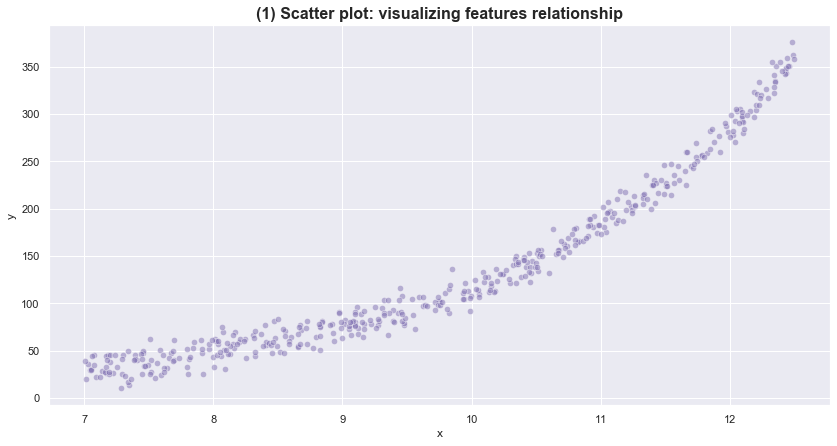

In [12]:
# First plot
plt.figure(figsize=(14,7))
plt.title("(1) Scatter plot: visualizing features relationship", fontsize=16, fontweight='bold')
scatter_plot = sns.scatterplot(x="x",y="y",data=df,s=40,color="m",alpha=0.50)

From the graph above it is possible to notice that there is evidence of a strong relationship between the features. Furthermore, it seems from the graph that the relationship is non-linear. This would imply that, rather than sticking with a simple linear regression, it might be necessary to add complexity in the model to better represent the trend highlighted here. If you are still not convinced, let's present further proofs using visualization techniques.

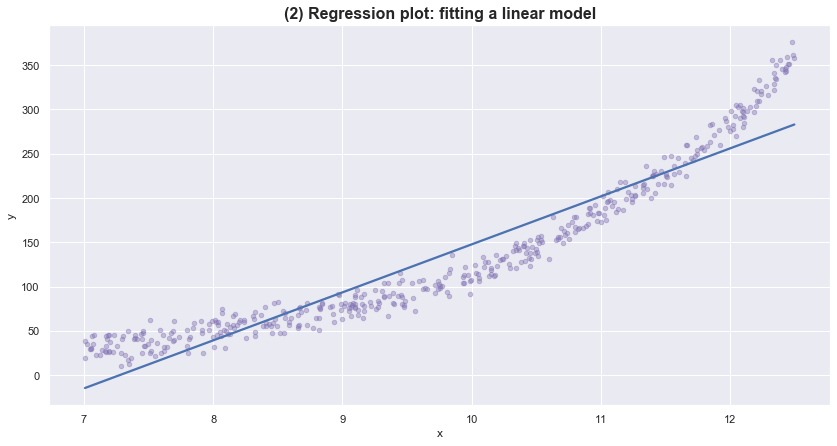

In [36]:
# Regression plot: scatter plot along with a fitted linear regression line 
plt.figure(figsize=(14,7))
plt.title("(2) Regression plot: fitting a linear model", fontsize=16, fontweight='bold')
reg_plot = sns.regplot(x="x", y="y", data=df, ci=None, scatter_kws={"s": 20, "color": "m","alpha": 0.40})

The graph above displays a scatter plot along with a fitted linear regression line. The model that presents this relationship may turn out to have a high score value (e.g. high R-Squared), but it would be relatively low given the evident trend represented in the graph. Indeed, it would almost certainly underfit the data. In other words, if a linear regression model is fitted with the above observations, there is high chance that it would be unable to accurately predict on unobserved data. As it has been already discussed before, in order to reach a better result, it might be the case to introduce complexity in the model. Let's see an example:

Text(0.5, 1, '(3) Regression plot: introducing non-linearity')

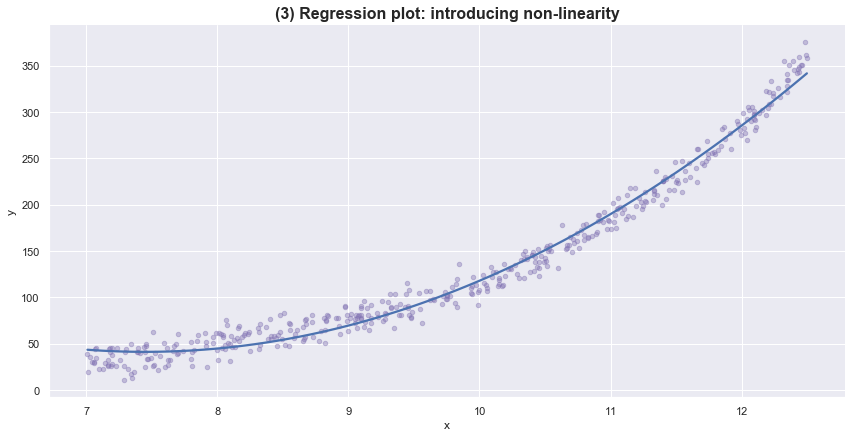

In [37]:
# Regression plot: scatter plot along with a 2-degree polynomial regression model
reg_plot_non_lin = sns.lmplot(x="x", y="y", data=df, order=2, ci=None, height=6, aspect=2, scatter_kws={"s": 20, "color": "m", "alpha":0.40})
ax = plt.gca()
ax.set_title("(3) Regression plot: introducing non-linearity",fontsize=16,fontweight='bold')

The graph above still represents a scatter plot along with a regression plot, but this time it is configured in such a way that it tries to fit a polynomial regression model on the data. The only difference with respect to the previous graph is the regression equation: rather than being linear, now it is quadratic. This little difference seems to be enough to get a more accurate model. 

One thing to notice here is that the polynomial order of the equation is set to 2. Configuring the model as such is enough to introduce non-linearity and complexity. However, from the graph it is clear that the line does not perfectly fit the data. 

Hence, a question that might be asked at this point is: can we do better than this by introducing additional complexity or by estimating using different models?

## (4) Data cleaning (Missing values)
In this section I wish to take care of issues that may arise from the data before proceeding to the modeling phase. In particular, this will be continuing the analysis of missing values conducted before.

### Dropping values?
As seen before, both the explanatory and the dependent variables present cases of missing values that needs to be handled before proceeding. Given that the overall percentage of missing values is 10% and given the clear trend already highlighted by the remaining data, dropping these observations seems to be the best option. 

### Imputing values?
A question that may arise at this point is whether it could be possible to find a way to impute the data rather than just dropping them?

Considering a simple imputer (e.g. one using mean or median strategy to impute the values), it would not work properly here as it would tend to approximate values towards a single point with the consequence of introducing biased information. Another approach that could be considered here is to impute them based on a K-Nearest-Neighbor imputer, which fits the data based on the characteristics of the K-th nearest observations and transform the missing data accordingly. On the one hand, given the strong evidence of a trend in the data, imputing the missing values would probably improve the model performances considerably, but on the other hand it might actually degenerate model predictive power due to additional assumptions on the structure of the data.

In [13]:
# (Dropping) -> choose to drop values
df.dropna(axis=0,subset=["x","y"], inplace=True)

## (5) Machine Learning Pipeline
Here comes the fun part! This section introduces two different regression model. I will first create a polynomial regression model and then it will possible to see whether, by introducing an ensemble model, performances can be increased from the starting point. To compute all the steps required to get the optimal model in a clear and nice fashion, I will make use of pipelines. One of the most important advantages of such approach is that you get a comprehensive object (the pipeline indeed) that can include data preprocessing, modeling, cross-validation and grid search procedures in one single object. Once defined, all you are required to do in order to get predictions is to istantiate the pipeline and invoke the proper method on the test data. The latter will automatically trigger the same preprocessing that was performed on the training data and returns the predictions.  

### Utilities
This section introduces two utilities: the first one being a customized column transformer to pass to the pipeline in order to get the proper shape of the data for the regression task, while the second is a dictionary containing two different metrics that will be injected into the GridSearchCV object to be used during the cross validation procedure to better evaluate a model performance. 

**N.B**. Despite the presence of two different evaluation metrics, cross validation will perform evaluation only using one of the two metrics. The second metric is provided in order to get a different perspective on the model performances.

In [14]:
# Column transformer to reshape the data before regression
class ReshapeTransformer(BaseEstimator,TransformerMixin):
    def fit(self,x,y=None):
        return self
    def transform(self,x,y=None):
        return x.values.reshape(-1,1)

In [15]:
# Scoring metrics dictionary
scoring={
    "r2":"r2",
    "neg_mean_squared_error":"neg_mean_squared_error"
}

### (5.1) Model 1. Polynomial Regression Model
Implementation of the first model: a polynomial regression model. In particular, the section starts by declaring a range of possible polynomial degrees as a parameter that will be injected into the pipeline to obtain the optimal model.

In [16]:
# Parameters for GridSearch in polynomial regression
param_grid_poly = {
    "polynomialfeatures__degree": range(2,31) # Define a range of possible polynomial degrees (from x**2 to x**30 [high-degree polynomial])
}

#### (5.1.1) Data prepocessing and model definition
The following method arranges all the prepocessing and model objects to be passed to the pipeline, which is eventually returned by the function

In [17]:
# Pipeline for the polynomial regression model
def get_pipeline_poly():
    # Column reshaping transformer
    my_reshape_transformer = ReshapeTransformer()
    # # KNN-based imputer
    # my_knn_imputer = KNNImputer()
    # Polynomial-degree transformer 
    my_poly_transformer = PolynomialFeatures()
    # Define the model
    my_poly_model = LinearRegression()
    # Define and return the pipeline: bundle together data preprocessing and model definition
    return make_pipeline(my_reshape_transformer, my_poly_transformer, my_poly_model)

#### (5.1.2) Model better evaluation using cross validation and fine-tuning model parameters using grid search
The following method retrieves the pipeline, which is then passed to the grid search optimization procedure. When the "fit" method is called, the procedure goes all the way through the pipeline to optimize the parameters while balancing between underfitting and overfitting and returning the optimal model.

In [18]:
# Get the optimal polynomial model
def get_optimal_poly(x=df.x,y=df.y,param_grid=param_grid_poly):
    # Retrieve the relative pipeline
    my_poly_pipeline = get_pipeline_poly()
    # istantiate the grid search object to perform parameter optimization and cross validation procedures based on negative MSE metric
    my_poly_optimal_model = GridSearchCV(my_poly_pipeline,param_grid,cv=5,scoring=scoring,refit="neg_mean_squared_error",verbose=3)
    # Fits the data and finds the best parameters according to GridSearchCV
    my_poly_optimal_model.fit(x,y)
    # Return the optimal polynomial model
    return my_poly_optimal_model

#### (5.1.3) Retrieve the optimal model
Istantiating the optimal polynomial model and print statistics

In [19]:
# Instantiate the optimal polynomial model
my_poly_optimal = get_optimal_poly()

Fitting 5 folds for each of 29 candidates, totalling 145 fits
[CV] polynomialfeatures__degree=2 ....................................
[CV]  polynomialfeatures__degree=2, neg_mean_squared_error=-159.359, r2=0.983, total=   0.0s
[CV] polynomialfeatures__degree=2 ....................................
[CV]  polynomialfeatures__degree=2, neg_mean_squared_error=-128.053, r2=0.978, total=   0.0s
[CV] polynomialfeatures__degree=2 ....................................
[CV]  polynomialfeatures__degree=2, neg_mean_squared_error=-150.615, r2=0.983, total=   0.0s
[CV] polynomialfeatures__degree=2 ....................................
[CV]  polynomialfeatures__degree=2, neg_mean_squared_error=-122.195, r2=0.985, total=   0.0s
[CV] polynomialfeatures__degree=2 ....................................
[CV]  polynomialfeatures__degree=2, neg_mean_squared_error=-150.140, r2=0.984, total=   0.0s
[CV] polynomialfeatures__degree=3 ....................................
[CV]  polynomialfeatures__degree=3, neg_mean_sq

In [20]:
# Get the optimal degree for polynomial regression equation
optimal_degree = my_poly_optimal.best_params_["polynomialfeatures__degree"]
# Print the optimal degree for polynomial features 
print(f"The optimal degree for polynomial features in the polynomial regression model is: {optimal_degree}")

The optimal degree for polynomial features in the polynomial regression model is: 6


In [21]:
# Get the metrics
poly_metrics = my_poly_optimal.cv_results_
# RMSE (Root Mean Squared Error)
print(f"Best polynomial regression model MSE: {(-1)*max(poly_metrics['mean_test_neg_mean_squared_error'])}")
# R2 (R-Squared)
print(f"Best polynomial regression model R2: {max(poly_metrics['mean_test_r2'])}")

Best polynomial regression model MSE: 100.86249894734247
Best polynomial regression model R2: 0.9874398493694626


### (5.2) Model 2. Ensemble Model (Gradient Boosting)
Introduction of the second model: Gradient Boosting. Being an ensemble model, Gradient Boosting works in a different way with respect to the polynomial regression model introduced before. In particular, what the model tries to do here (in simple words) is to start with a base learner defined with defualt parameters (if not specified) and then iteratevly add other base learners into an ensemble model with the aim of improving at each cycle the model performances on the data. How does it do this? By minimizing the cost function using the gradient descending algorithm. 

Furthermore, gradient boosting gives high degree of flexibility in setting parameters of the base learners and this is the reason why it has been choosen as the second model. The aim here with the model is to see whether, based on the results achieved with the first model, it is possible to set the parameters to further increase model performances while avoiding overfitting.

In [23]:
# Parameter grid containing the possible parameters values to be optimized through GridSearchCV. 
# Each parameter will be passed through the pipeline and will be assigned to the object name accordingly
param_grid_ensemble = {
    "polynomialfeatures__degree": [optimal_degree], # already optimized in the previous model
    "xgbregressor__objective": ["reg:squarederror"], 
    "xgbregressor__booster": ["gblinear"], # change to GLM (Generalized Least Square) rather than tree-based learners
    "xgbregressor__learning_rate": [0.5], # percentage of contribution of each new base learner 
    "xgbregressor__n_estimators": [1000], # number of base learners iteratively trained
    "xgbregressor__early_stopping_rounds": [5], # rounds of straight deterioration allowed before stopping
    "xgbregressor__gamma": [5], # regularization
}

#### (5.2.1) Data prepocessing and model definition

In [24]:
# Pipeline for the ensemble model
def get_ensemble_pipeline():
    # Column reshaping transformer
    my_reshape_transformer = ReshapeTransformer()
    # # [TODO] Standardize columns to increase gradient descending performance
    # my_standardizer_transformer = StandardScaler() 
    # Get the proper polynomial features in the data
    my_poly_transformer = PolynomialFeatures()
    # Define the model
    my_ensemble_model = XGBRegressor()
    # Define and return the pipeline for the ensemble method
    return make_pipeline(my_reshape_transformer,my_poly_transformer,my_ensemble_model)

#### (5.2.2) Model better evaluation using cross validation and fine-tuning model parameters using grid search

In [25]:
# Retrieve the optimal Gradient Boosting model 
def get_optimal_ensemble(x=df.x,y=df.y,param_grid=param_grid_ensemble):
    # Retrieve the relative pipeline
    my_pipeline = get_ensemble_pipeline()
    # Istantiate the grid search object to perform parameter optimization and cross validation procedures based on negative MSE metricng
    my_ensemble_model = GridSearchCV(my_pipeline,param_grid,cv=5,scoring=scoring,refit="neg_mean_squared_error",verbose=3)
    # Fits the data and finds the best parameters according to GridSearchCV
    my_ensemble_model.fit(x,y)
    # Return the optimal ensemble model
    return my_ensemble_model

#### (5.2.3) Retrieve the optimal model

In [26]:
# Istantiate the optimal ensemble model
my_ensemble_optimal = get_optimal_ensemble()

Fitting 5 folds for each of 1 candidates, totalling 5 fits
[CV] polynomialfeatures__degree=6, xgbregressor__booster=gblinear, xgbregressor__early_stopping_rounds=5, xgbregressor__gamma=5, xgbregressor__learning_rate=0.5, xgbregressor__n_estimators=1000, xgbregressor__objective=reg:squarederror 
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV]  polynomialfeatures__degree=6, xgbregressor__booster=gblinear, xgbregressor__early_stopping_rounds=5, xgbregressor__gamma=5, xgbregressor__learning_rate=0.5, xgbregressor__n_estimators=1000, xgbregressor__objective=reg:squarederror, neg_mean_squared_error=-115.758, r2=0.988, total=   0.4s
[CV] polynomialfeatures__degree=6, xgbregressor__booster=gblinear, xgbregressor__early_stopping_rounds=5, xgbregressor__gamma=5, xgbregressor__learning_rate=0.5, xgbregressor__n_estimators=1000, xgbregressor__objective=reg:squarederror 
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.3s remaining:    0.0s
[CV]  polyn

In [27]:
# Get the metrics
ensemble_metrics = my_ensemble_optimal.cv_results_
# RMSE (Root Mean Squared Error)
print(f"Best ensemble model MSE: {(-1)*max(ensemble_metrics['mean_test_neg_mean_squared_error'])}")
# R2 (R-Squared)
print(f"Best ensemble model R2: {max(ensemble_metrics['mean_test_r2'])}")

Best ensemble model MSE: 104.93747009479841
Best ensemble model R2: 0.9870880112090752


## (6) Get the best model (metric comparison)
Here the aim is to obtain the best performing model between the two proposed above by comparing their evaluation metrics

In [29]:
# Check which model has the lowest averaged mean squared error (MSE) on test set

# Retrieve the best scores from both models (multiplied by (-1) due to negative valued metrics)
best_score_poly = (-1)*my_poly_optimal.best_score_
best_score_ensemble = (-1)*my_ensemble_optimal.best_score_

# Retrieve and store the optimal model
if best_score_poly < best_score_ensemble:
    print(f"The best performing model is Polynomial Regression Model with a MSE of: {best_score_poly}")
    my_best_model = my_poly_optimal
else:
    print(f"The best performing model is Polynomial Regression Model with a MSE of: {best_score_ensemble}")
    my_best_model = my_ensemble_optimal

The best performing model is Polynomial Regression Model with a MSE of: 100.86249894734247


# (7) Evaluate the system on a test set and plot the results
Here are presented two different plots: 

1. The first plot displays the predictions of the best model against the true data. Moreover, it fits a 45° bisector of the first quadrant in order get a sense of how accurate the model has been in predicting values
2. The second plot gives further evidence of the trend highlighted in the first plot by comparing the predictions of the best model with the true data on the test set

Start by dividing into the dataset into train-test data and compute and store the predictions of the best model

In [30]:
# Divide data into train-test
x_train_best,x_test_best,y_train_best,y_test_best = train_test_split(df.x,df.y,random_state=1)

# Target predictions using the best model
y_preds_best = my_poly_optimal.predict(x_test_best)

#### Plot 1. Predictions against true data

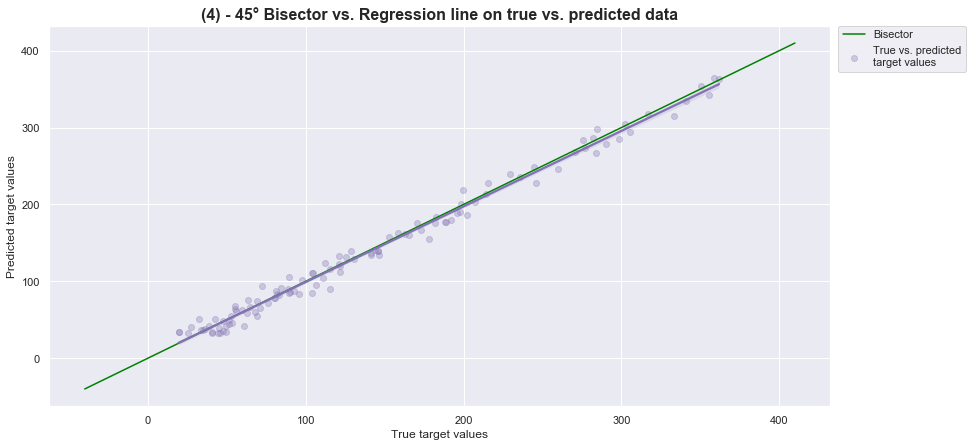

In [33]:
# Plot predicted values against true data

# (1) Define the bisector (as a metric to compare)

# Get the range 
step = 50
start = int(min(min(y_preds_best), df.y.min())) - step
stop = int(max(max(y_preds_best),df.y.max())) + step

# Get the bisector dataframe
arange = np.arange(start=start,stop=stop,step=step,dtype=np.int32)
arange_repeated = np.repeat(arange.reshape(-1,1),repeats=2,axis=1)
bisector_df = pd.DataFrame(data=arange_repeated,columns=["x","y"])

# (2) Plot the bisector against the regression on true vs. predicted data
# Configuration
plt.figure(figsize=(14,7))
# Plots
sns.lineplot(x="x",y="y",data=bisector_df, color="green",label="Bisector") 
sns.regplot(x=y_test_best, y=y_preds_best, color='m', label="True vs. predicted\ntarget values", scatter_kws={"alpha":0.3})

# Makes
plt.title("(4) - 45° Bisector vs. Regression line on true vs. predicted data", fontsize=16,fontweight='bold')
plt.xlabel("True target values")
plt.ylabel("Predicted target values")
plt.legend(bbox_to_anchor=(1.01, 1), loc=2, borderaxespad=0.)

# (3) Save figure
plt.savefig("4_bisector_vs_reg_true_predicted.png",dpi=300)

The figure above compares predictions from the best model with the true data. The graph should be read as follow: the closer the violet line gets to the green line, the better. Here, the regression line (violet) estimated on the predictions and the true data gets really close to the 45° bisector of the first quadrant (green) along all the graph, and in certain points they even overlap. This is a clear signal that the model performs really well on average!

#### Plot 2. Predictions and true data

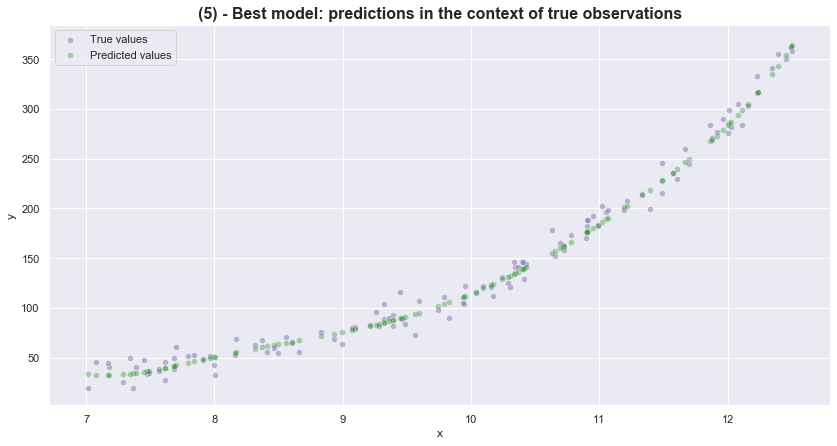

In [34]:
# Plot the predicted values in the context of true data

# (1) Configure graph
plt.figure(figsize=(14,7))
# Predicte values against 
plt.title("(5) - Best model: predictions in the context of true observations",fontsize=16,fontweight='bold')
# # (2) True data
sns.scatterplot(x=x_test_best, y=y_test_best, color='m', alpha=0.5, label="True values")
# # (3) Best model predictions
sns.scatterplot(x=x_test_best, y=y_preds_best, color='green', alpha=0.3, label="Predicted values")
# # (4) Save the graph
plt.savefig("5_true_preds_plot.png",dpi=300)

This graph gives a different perspective of the trend highlighted in the graph above. Indeed, it can be noticed from here that the predictions of the best model gets really close to the true values on average.

### Export all plots

In [38]:
# Save all the plots produced
scatter_plot.figure.savefig("1_scatter_plot.png",dpi=300)
reg_plot.figure.savefig("2_regression_plot.png",dpi=300)
reg_plot_non_lin.savefig("3_regression_plot_non_lin.png",dpi=300)

# (8) Conclusions
Here I give an overview of the solution and my findings! 

The analysis started by exploring the main characteristics of the dataset. In particular, it was possible to notice that, despite the small number of observations, the features were characterized by a strong relationship that would require to introduce non-linearity to be captured properly. The presence of missing values required careful evaluation of multiple solutions before deciding to drop them.

Then came the modeling phase. Aware that the relationship between the two features was polynomial, it was decided to first introduce a polynomial regression model that was carefully optimized based on a grid search procedure to find the optimal high-degree polynomial equation that best represented the data. Since the model in question had already a really high score (in terms of R2), as a second model it was decided to introduce an ensemble method, which, given the higher flexibility in setting the parameters, may contribute in lowering down even further the metric that has been used to evaluate model performance: mean square error (MSE). However, the opposite happened: the final model on average was performing worse than the polynomial model on test data. What are the reasons for such result? 

Well, there might be several reasons and the fact that there is a relative small dataset is probably one of the key factor. Indeed, it might be the case that, given a bigger dataset (10.000 observations or more), the likelihood of outliers in the data would definately increase and the probability that the ensemble method would generalize better on such dataset may increase either. On the other hand, finding the right parameters for a gradient boosting model is a complex task and might lead to overfitting data if not treated carefully. 

To conclude the analysis, the predictions of the best model (polynomial regression model) on our test data against the true test data were presented in a graph. From the latter is possible to notice the model accuracy in predicting values. Indeed, the 45° bisector of the first quadrant almost coincides with a linear regression calculated on the true data and the predictions of the model. This fact, along with the conclusion derived from the last graph displaying how the predictions would fit with the true data on the test set, gives clear evidence of the predictive power of the model.

# (9) (Bonus) Further improvements
When the statistics of the dataset were first analyzed, it has been highlighted that the features were presenting different means and variances and that this fact could be due to different distributions or becuase they may have equal distributions with different parameters. Although it was stated that such findings wouldn't be of any help for our purposes (referring to whether it would be appropriate or not to rescale the variables), they might come in handy if moved to the context of missing values. Why?

Let's imagine that it is possible to understand the distributions from which the data have been drawn from and that it is also possible to correctly estimate the parameters of such distributions. At this point, for each of the feature, it could be performed a random sampling from a simulated distribution described by the parameters infered before and subsequently injected to substitute the missing values in the dataset. Such procedure would require to first explore the distribution of each feature using univariate analysis and visualization and tp apply statistical procedures to come up with an appropriate estimator of the parameter. 

Despite being an interesting approach to take, it may require a lot of effort from an analytical point of view, which may not be worthy for a relatively small dataset and for an already clear trend highlighted by the data as in this case